In [1]:
import torch
import os
import argparse
from argparse import Namespace
from pprint import pprint
from functools import partial
from transformers import (AutoTokenizer,
                          AutoModelForSeq2SeqLM,
                          AutoModelForCausalLM,
                          OPTForCausalLM,
                          LogitsProcessorList)
from collections import Counter
from nltk.util import ngrams 
import json
from watermark_processor import WatermarkLogitsProcessor, WatermarkDetector
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/wayne/miniconda3/envs/lm-watermarking1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## modified code from kirchenbauer. Changed to generate a custom number of samples
def generate(prompt, args, model=None, device=None, tokenizer=None, times=1):
    """Instatiate the WatermarkLogitsProcessor according to the watermark parameters
       and generate watermarked text by passing it to the generate method of the model
       as a logits processor. """
    
    print(f"Generating with {args}")

    watermark_processor = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()),
                                                    gamma=args.gamma,
                                                    delta=args.delta,
                                                    seeding_scheme=args.seeding_scheme,
                                                    select_green_tokens=args.select_green_tokens)

    gen_kwargs = dict(max_new_tokens=args.max_new_tokens)

    if args.use_sampling:
        gen_kwargs.update(dict(
            do_sample=True, 
            top_k=0,
            temperature=args.sampling_temp
        ))
    else:
        gen_kwargs.update(dict(
            num_beams=args.n_beams
        ))

    generate_without_watermark = partial(
        model.generate,
        **gen_kwargs
    )
    generate_with_watermark = partial(
        model.generate,
        logits_processor=LogitsProcessorList([watermark_processor]), 
        **gen_kwargs
    )
    #if args.prompt_max_length:
    #    pass
    #elif hasattr(model.config,"max_position_embedding"):
    #    args.prompt_max_length = model.config.max_position_embeddings-args.max_new_tokens
    #else:
    #    args.prompt_max_length = 2048-args.max_new_tokens
    
    args.prompt_max_length = args.max_new_tokens
    tokd_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True, truncation=True, max_length=args.prompt_max_length).to(device)
    # print("Input IDs")
    # print(tokd_input["input_ids"][0][0])
    #print(watermark_processor._get_greenlist_ids(tokd_input["input_ids"]))
    truncation_warning = True if tokd_input["input_ids"].shape[-1] == args.prompt_max_length else False
    redecoded_input = tokenizer.batch_decode(tokd_input["input_ids"], skip_special_tokens=True)[0]
    #print(watermark_processor._get_greenlist_ids(redecoded_input))

    torch.manual_seed(args.generation_seed)
    
    corpus_without_watermark = []
    for i in range(times):
        # print(i)
        output_without_watermark = generate_without_watermark(**tokd_input)
        # print(output_without_watermark)
        corpus_without_watermark.append(tokenizer.decode(output_without_watermark[0], skip_special_tokens=False))
    
    # output_without_watermark = generate_without_watermark(**tokd_input)

    # optional to seed before second generation, but will not be the same again generally, unless delta==0.0, no-op watermark
    if args.seed_separately: 
        torch.manual_seed(args.generation_seed)
    
    corpus_with_watermark = []
    for i in range(times):
        output_with_watermark = generate_with_watermark(**tokd_input)
        corpus_with_watermark.append(tokenizer.decode(output_with_watermark[0], skip_special_tokens=False))
    
    
    
    
    # output_with_watermark = generate_with_watermark(**tokd_input)

    if args.is_decoder_only_model:
        # need to isolate the newly generated tokens
        output_without_watermark = output_without_watermark[:,tokd_input["input_ids"].shape[-1]:]
        output_with_watermark = output_with_watermark[:,tokd_input["input_ids"].shape[-1]:]

    # decoded_output_without_watermark = tokenizer.batch_decode(output_without_watermark, skip_special_tokens=True)[0]
    # decoded_output_with_watermark = tokenizer.batch_decode(output_with_watermark, skip_special_tokens=True)[0]

    return (tokd_input,
            watermark_processor,
            output_without_watermark,
            # redecoded_input,
            # int(truncation_warning),
            #decoded_output_without_watermark, 
            #decoded_output_with_watermark,
            #output_without_watermark,
            #output_with_watermark,
            corpus_without_watermark,
            corpus_with_watermark,
            args) 

In [3]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-125m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])

# input_text = ""

# device = "gpu"

In [4]:
def load_model(args):
    """Load and return the model and tokenizer"""

    args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
    args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])
    if args.is_seq2seq_model:
        model = AutoModelForSeq2SeqLM.from_pretrained(args.model_name_or_path)
    elif args.is_decoder_only_model:
        if args.load_fp16:
            model = AutoModelForCausalLM.from_pretrained(args.model_name_or_path,torch_dtype=torch.float16, device_map='auto')
        else:
            model = AutoModelForCausalLM.from_pretrained(args.model_name_or_path)
    else:
        raise ValueError(f"Unknown model type: {args.model_name_or_path}")

    if args.use_gpu:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if args.load_fp16: 
            pass
        else: 
            model = model.to(device)
            # print("hi")
    else:
        device = "cpu"
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path)
    # tokenizer = tokenizer.to(device)

    return model, tokenizer, device

In [5]:
model, tokenizer, device = load_model(args)
# device = "gpu

In [10]:
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=1)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-125m', load_fp16=False, prompt_max_length=None, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


I finally worked out how to extract the greenlist.
The greenlist is dependent on the word that we input. That's the whole point.
So when iterating, we want to put it through the method _get_greenlist_ids.
So let's extract the watermark processor from the generate function and then use that to generate the greenlist based on the words.

In [52]:
import os
path_watermarked = 'corpora_with_watermark/'
json_file_names = [filename for filename in os.listdir(path_watermarked) if filename.endswith('.json')]
# print(json_file_names)
corpus_with_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_watermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_with_watermark += foo

# print(corpus_with_watermark)

In [53]:
path_nonwatermarked = 'corpora_without_watermark/'
json_file_names = [filename for filename in os.listdir(path_nonwatermarked) if filename.endswith('.json')]
corpus_without_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_nonwatermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_without_watermark += foo

In [6]:
def p_hat(word1, word2, word_dict, n_gram_dict):
    # word_dict = get_word_dict(corpus)
    if (not word1 in word_dict) or (not word2 in word_dict):
        prob = 0
        return prob
    assert word1 in word_dict, "word1 is not in corpus"
    assert word2 in word_dict, "word2 is not in corpus"
    # n_gram_dict = get_n_gram_dict(corpus)
    prob = n_gram_dict[(word1, word2)] / word_dict[word2]
    assert prob >= 0 and prob <= 1, "probability is not between 0 and 1"
    return prob

def get_word_dict(corpus):
    word_freqs = defaultdict(int)
    for text in corpus:
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
        new_words = [word for word, offset in words_with_offsets]
        for word in new_words:
            word_freqs[word] += 1
    return word_freqs

def get_n_gram_dict(corpus, n_gram=2):
    bigram_freqs = Counter()
    for text in corpus:
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
        new_words = [word for word, offset in words_with_offsets]
        bigram_freqs += Counter(ngrams(new_words, n_gram))
    return defaultdict(int, dict(bigram_freqs))

In [54]:
word_dict_w = get_word_dict(corpus_with_watermark)
n_gram_dict_w = get_n_gram_dict(corpus_with_watermark)

word_dict_nw = get_word_dict(corpus_without_watermark)
n_gram_dict_nw = get_n_gram_dict(corpus_without_watermark)

In [37]:
p_hat('The', 'Ġfact', word_dict_w, n_gram_dict_w)

NameError: name 'word_dict_w' is not defined

In [36]:
p_hat('The', 'Ġfact', word_dict_nw, n_gram_dict_nw)

0.15384615384615385

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [18]:
## Attempting to implement Algorithm 2
# TODO: Change code so that it runs via vector form! Do not use for loops for sum, speeds up the code a lot.
# TODO: add tqdm
# vocab_size = tokenizer.vocab_size

def L(delta, w, word_dict, n_gram_dict, watermark_processor): # why did I add tokenizer_vocab lol
    L = 0
    greenlist_w, redlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode(w)), get_redlist=True)
    greenlist_w = tokenizer.convert_ids_to_tokens(greenlist_w)
    redlist_w = tokenizer.convert_ids_to_tokens(redlist_w)
    
    for word in list(word_dict.keys())[:100]:
        greensum = 0 
        redsum = 0
        for wdash in greenlist_w:
            green = p_hat(wdash, word, word_dict, n_gram_dict)
            if green != 0:
                print("green = ", green)
                greensum += green
        for wdash in redlist_w:
            redsum += p_hat(wdash, word, word_dict, n_gram_dict)
        if not (greensum == 0 and redsum == 0):
            L -= np.log(np.exp(delta) * greensum + redsum)
        if w in greenlist_w:
            L += delta
    return L, redsum

In [19]:
#greenlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode("hello")).to(device))
#int(tokenizer.vocab.values()

path_nonwatermarked = 'corpora_without_watermark/'
with open(os.path.join(path_nonwatermarked, 'corpus_without_watermark.json')) as json_file:
    corpus_without_watermark = json.load(json_file)

word_dict_nw = get_word_dict(corpus_without_watermark)
n_gram_dict_nw = get_n_gram_dict(corpus_without_watermark)



deltaarr = np.arange(0, 1, 0.1)
# deltaarr
Larr, redsum = L(deltaarr, 'Ġup', word_dict_nw, n_gram_dict_nw, watermark_processor)
#print(redsum)
# plt.plot(deltaarr, Larr)

green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0019267822736030828
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0009633911368015414
green =  0.0010368066355624676
green =  0.0005184033177812338
green =  0.9908316961362148
green =  0.125
green =  0.017663043478260868
green =  0.019021739130434784
green =  0.005434782608695652
green =  0.005434782608695652
green =  0.019230769230769232
green =  0.0007462686567164179
green =  0.0029850746268656717
green =  0.0007462686567164179
green =  0.012686567164179104
green =  0.0007462686567164179
green =  0.0014925373134328358
green =  0.0007462686567164179
green =  0.0007462686567164179
green =  0.0014925373134328358
green =  0.0007462686567164179
gr

In [20]:
Larr

array([70.22071552, 65.06980917, 59.77360763, 54.33384063, 48.75270298,
       43.03282666, 37.17724708, 31.18936472, 25.0729031 , 18.83186427])

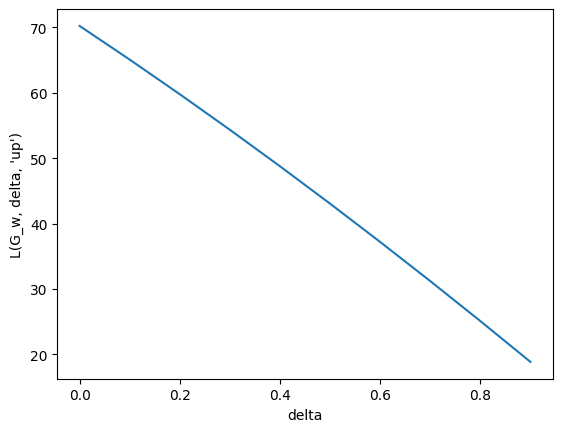

In [21]:
# Larr = L(deltaarr, 'Ġup', word_dict_nw, n_gram_dict_nw, watermark_processor)
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [45]:
## L gradient descent

optim = torch.optim.SGD()

tensor([[  113,  1711,    21,   269,  3035,   113,  1437,  1437,    22, 14783,
            38,   218,    75,   216,   932,    59,   930,     8,    38,  3996,
             5,   569,   113,  1437,  1437,    22,   100,   218,    75,   216,
           932,    59,   930,   113,  1437,  1437,    22,  2847,    99,    32,
            47,   608,    19,   110,  1730,  1917,  1437,  1437,    22,   100,
           437,  6908,   120,   106,     7,  3836,   113, 50118,   243,    18,
            67,     5,   275,  2214,    11,     5,  1445,  2642,   328,     2]])
